# **Singular Value Decomposition**

A good introduction to SVD for ML can be found at https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/, and an excellent visual tutorial is given here: https://towardsdatascience.com/svd-8c2f72e264f.
Here, I implement SVD on different matrices using NumPy and visualise the results to gain an intuition for the algorithm.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def plot_matrices(matrix_list, titles, show_vals=True, colormap='plasma'):
    fig, ax = plt.subplots(nrows=1, ncols=len(matrix_list), figsize=[len(matrix_list) * 5 ,5])
    for mat_idx, mat in enumerate(matrix_list):
        ax[mat_idx].imshow(mat, colormap)
        ax[mat_idx].set_title(titles[mat_idx])
        ax[mat_idx].set_xticks([])
        ax[mat_idx].set_yticks([])
        if show_vals ==  True:
            for (row,col), label in np.ndenumerate(mat):
                ax[mat_idx].text(col, row, f'{label:.1f}', ha='center', va='center', c='gray')

In [3]:
# create some sample matrices to perform SVD on
X = np.empty([10,10])
Y = np.empty([10,10])
for row_idx in range(np.shape(X)[0]):
    for col_idx in range(np.shape(X)[1]):
        X[row_idx, col_idx] = col_idx
        Y[row_idx, col_idx] = row_idx

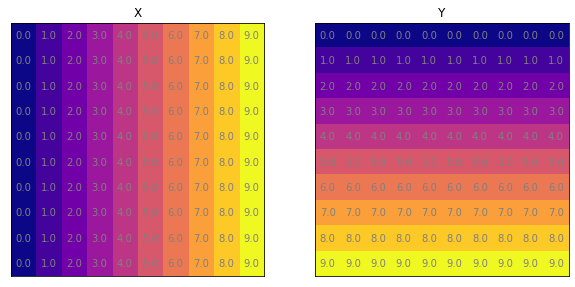

In [4]:
# visualise the matrices
plot_matrices([X,Y], ['X', 'Y'])

In [5]:
# perform the SVD
U_X, s_X, VT_X = np.linalg.svd(X)
U_Y, s_Y, VT_Y = np.linalg.svd(Y)

In [6]:
# create Sigma from s
Sigma_X = np.zeros((X.shape[0], X.shape[1]))
Sigma_Y = np.zeros((X.shape[0], X.shape[1]))
Sigma_X[:X.shape[1], :X.shape[1]] = np.diag(s_X)
Sigma_Y[:Y.shape[1], :Y.shape[1]] = np.diag(s_Y)

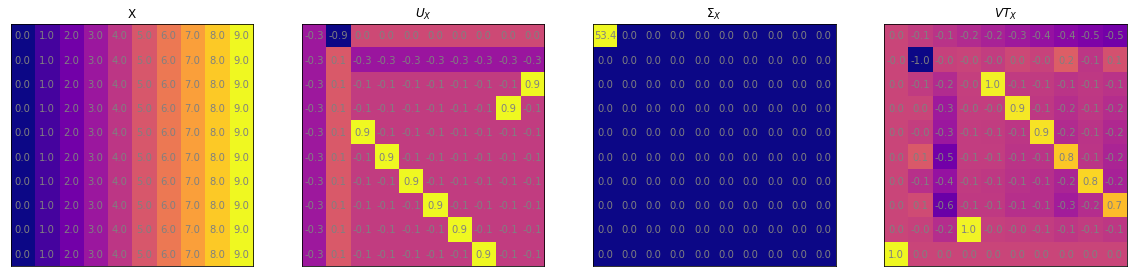

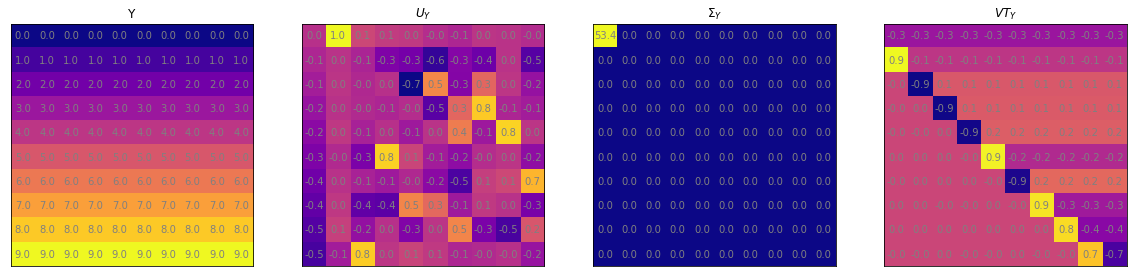

In [7]:
# visualise the decomposed matrices
# (original matrix = left-singular vectors * singular values * right-singular vectors (transposed))
plot_matrices([X, U_X, Sigma_X, VT_X], ['X', '$U_X$', '$\Sigma_X$', '$VT_X$'])
plot_matrices([Y, U_Y, Sigma_Y, VT_Y], ['Y', '$U_Y$', '$\Sigma_Y$', '$VT_Y$'])

* The rows of VT (or, equivalently) columns of VT) represent the right-singular vectors of the original matrix, the diagonals of Sigma represent the singular values (the weights of each singular vector in the original matrix), and the columns of U represent the left-singular vectors of the original matrix
* The left-singular vectors form an orthonormal basis for the column space of the original matrix, and the right-singualr vectors form an orthonormal basis for the row space of the original matrix
* Geometrically, U and V correspond to rotations, and Sigma corresponds to a scaling
* In both of the examples here, only the first singular value of Sigma is non-zero, implying that X and Y are rank suggesting that X and Y are composed only of one strong component in each case

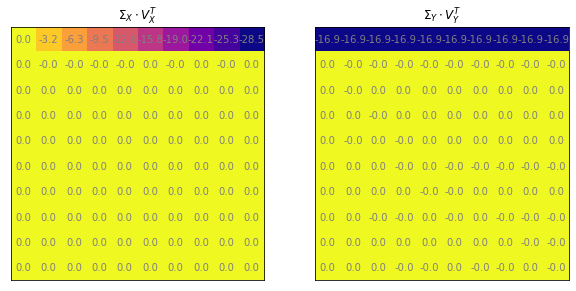

In [8]:
# reconstruct matrices halfway 
Sigma_VT_X = Sigma_X.dot(VT_X) 
Sigma_VT_Y = Sigma_Y.dot(VT_Y)
plot_matrices([Sigma_VT_X, Sigma_VT_Y], ['$\Sigma_{X} \cdot V^{T}_{X}$', '$\Sigma_{Y} \cdot V^{T}_{Y}$'])

Looking at the first row of the matrix from the first step of reconstruction of X, it can be seen that the element in each column is proportional to the values in the comns of X, and the same applies to Y (but all the values are equal so this pattern is not immediately obvious).

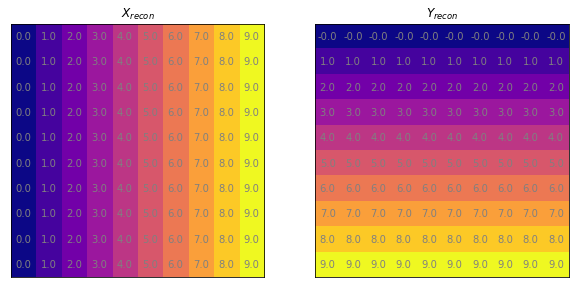

In [9]:
# reconstruct completely
X_recon = U_X.dot(Sigma_VT_X)
Y_recon = U_Y.dot(Sigma_VT_Y)
plot_matrices([X_recon, Y_recon], ['$X_{recon}$', '$Y_{recon}$'])

It is difficult to do much useful by performing SVD on these matrices as all of the columns are equal in X, and all the rows are equal in Y.

**Image denoising with SVD**

Let's try doing something more useful by taking some noisy image data and attempting to denoise it using SVD. This will involve finding the singular values corresponding to noise, zeroing these out and then reconstructing the images.

In [70]:
# load image
cat_img = cv2.imread("../data/cat.jpg", cv2.IMREAD_GRAYSCALE)
# reshape to be square
cat_img = cat_img[:np.shape(cat_img)[0], :np.shape(cat_img)[0]]

Text(0.5, 1.0, 'Gaussian noise ($\\sigma^2 = 100$)')

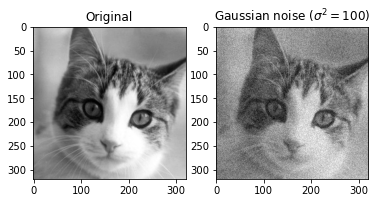

In [71]:
# add noise
noise_var = 100
cat_noisy = cat_img + np.random.random(size=np.shape(cat_img)) * noise_var
# visualise
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(cat_img, cmap='gray')
ax[0].set_title(f'Original')
ax[1].imshow(cat_noisy, cmap='gray')
ax[1].set_title(f'Gaussian noise ($\sigma^2 = {noise_var}$)')

In [72]:
# perform SVD
U_cat, s_cat, VT_cat = np.linalg.svd(cat_img)

In [73]:
# create Sigma from s
Sigma_cat = np.zeros((cat_noisy.shape[0], cat_noisy.shape[1]))
Sigma_cat[:cat_img.shape[1], :cat_img.shape[1]] = np.diag(s_cat)

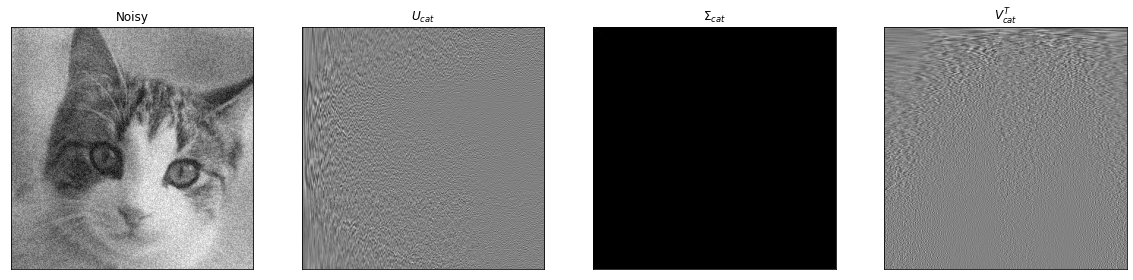

In [74]:
# visualise the decomposed matrices
plot_matrices([cat_noisy, U_cat, Sigma_cat, VT_cat], ['Noisy', '$U_{cat}$', '$\Sigma_{cat}$', '$V^{T}_{cat}$'], colormap='gray', show_vals=False)

Let's look closer at the singular values.

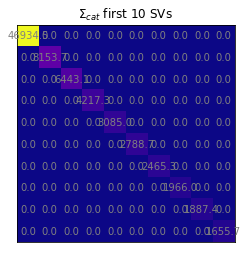

In [75]:
plt.imshow(Sigma_cat[:10,:10], cmap='plasma')
plt.title('$\Sigma_{cat}$ first 10 SVs')
plt.xticks([])
plt.yticks([])
for (row,col), label in np.ndenumerate(Sigma_cat[:10,:10]):
    plt.text(col, row, f'{label:.1f}', ha='center', va='center', c='gray')

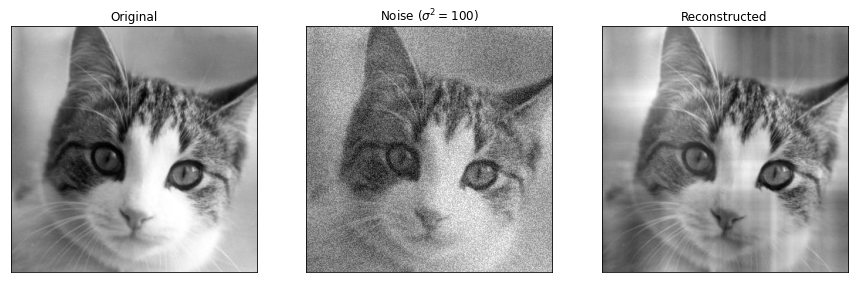

In [76]:
# let's try zeroing out the first singular value
Sigma_cat_recon[:,:] = Sigma_cat[:,:]
Sigma_cat_recon[0,0] = 0
cat_recon = U_cat.dot(Sigma_cat_recon.dot(VT_cat))
# visualise results to compare
plot_matrices([cat_img, cat_noisy, cat_recon], ['Original', f'Noise ($\sigma^2 = {noise_var}$)', 'Reconstructed'], show_vals=False, colormap='gray')

It looks like we have removed an SV corresponding to a lot of the original image and kept the noise. 

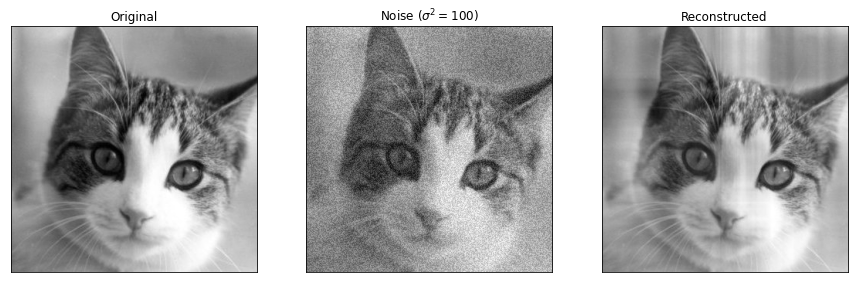

In [84]:
# let's try zeroing out the second singular value instead
Sigma_cat_recon[:,:] = Sigma_cat[:,:]
Sigma_cat_recon[1,1] = 0
cat_recon = U_cat.dot(Sigma_cat_recon.dot(VT_cat))
plot_matrices([cat_img, cat_noisy, cat_recon], ['Original', f'Noise ($\sigma^2 = {noise_var}$)', 'Reconstructed'], show_vals=False, colormap='gray')

This seems to have worked better. A more in-depth interrogation into the contribution of the singular values would reveal exactly which SVs should be kept and discarded to denoise the image. This may be labour-intensive at first (though could be automated), but should work well for other images which follows the same image and noise statistics. This same approach can be applied for image compression.